# Natural Language Processing with Disaster Tweets

## Problem Description

This is a text classification problem in the field of Natural Language Processing (NLP). The task is to classify tweets on Twitter to determine whether a tweet is actually about a real disaster or not.

This is a binary classification problem, where the model needs to learn how to understand the context and meaning of text to make accurate decisions.

## Project Objectives

Build an RNN (Recurrent Neural Network) model capable of:
- Understanding the context and meaning of tweet text
- Accurately distinguishing between tweets about real disasters and unrelated tweets
- Achieving good accuracy on the test dataset

## Technologies Used

- **Deep Learning**: RNN (LSTM/GRU) for processing sequential data
- **NLP Libraries**: NLTK, spaCy, or other text processing libraries
- **Deep Learning Frameworks**: TensorFlow/Keras or PyTorch
- **Evaluation Metric**: F1-score (commonly used in imbalanced classification problems)





In [15]:
# Import necessary libraries
from pickletools import pystring
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')

# Deep Learning and NLP libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# NLP libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load training and test data
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

print(train_df.head())
print(train_df.info())
print(test_df.info())


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
<class 'pandas.core.frame.DataFrame'

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/hoangnp/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hoangnp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/hoangnp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Description

### Data Structure

The data is divided into 3 main files:

1. **train.csv**: Training data
   - **Size**: Approximately 8,561 samples
   - **Columns**:
     - `id`: Unique identifier for each tweet
     - `keyword`: Disaster-related keyword (may have null values)
     - `location`: Geographic location (may have null values)
     - `text`: Tweet content (text to be classified)
     - `target`: Classification label (0 = not a disaster, 1 = real disaster)

2. **test.csv**: Test data
   - **Size**: Approximately 3,699 samples
   - **Columns**: Similar to train.csv but without the `target` column
   - Purpose: Predict labels for tweets in the test set

### Data Characteristics

- **Data Type**: Short text (tweets) - typically limited length (maximum 280 characters for Twitter)
- **Language**: English
- **Format**: CSV (Comma-Separated Values)

### Label Distribution

The training data contains two classes:
- **Class 0**: Tweet not about a real disaster
- **Class 1**: Tweet about a real disaster

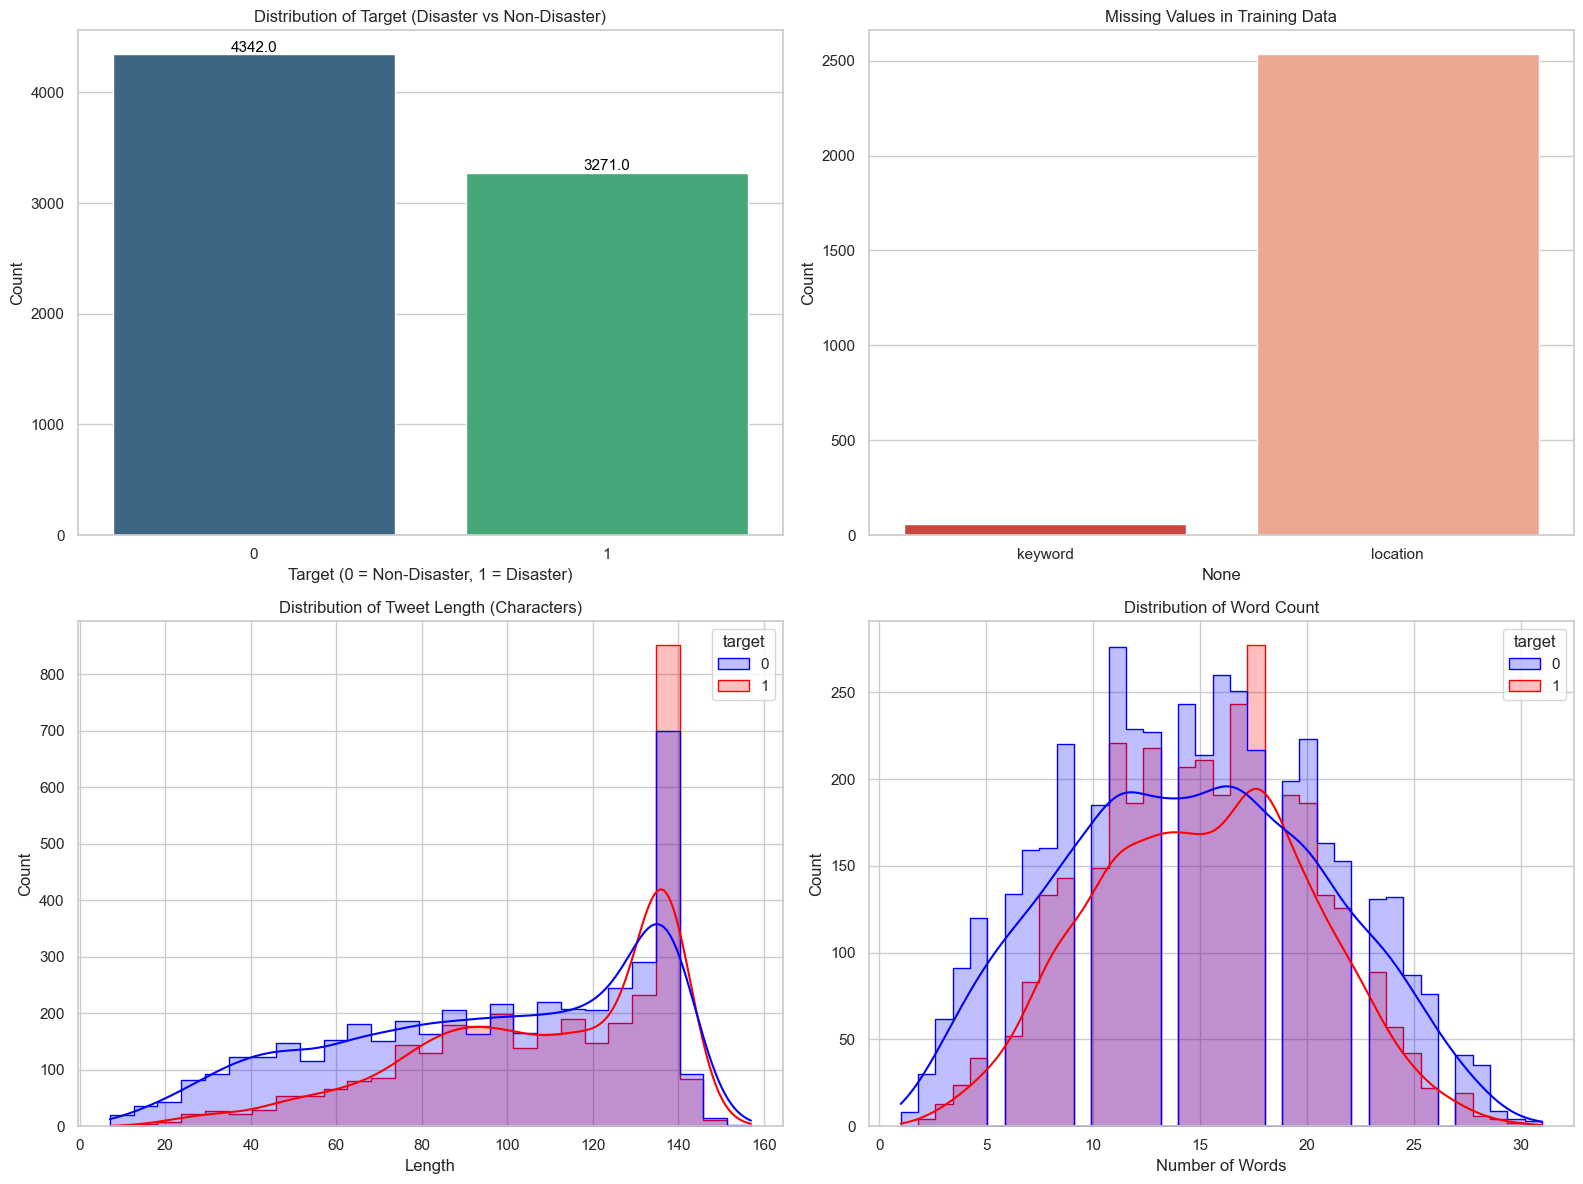

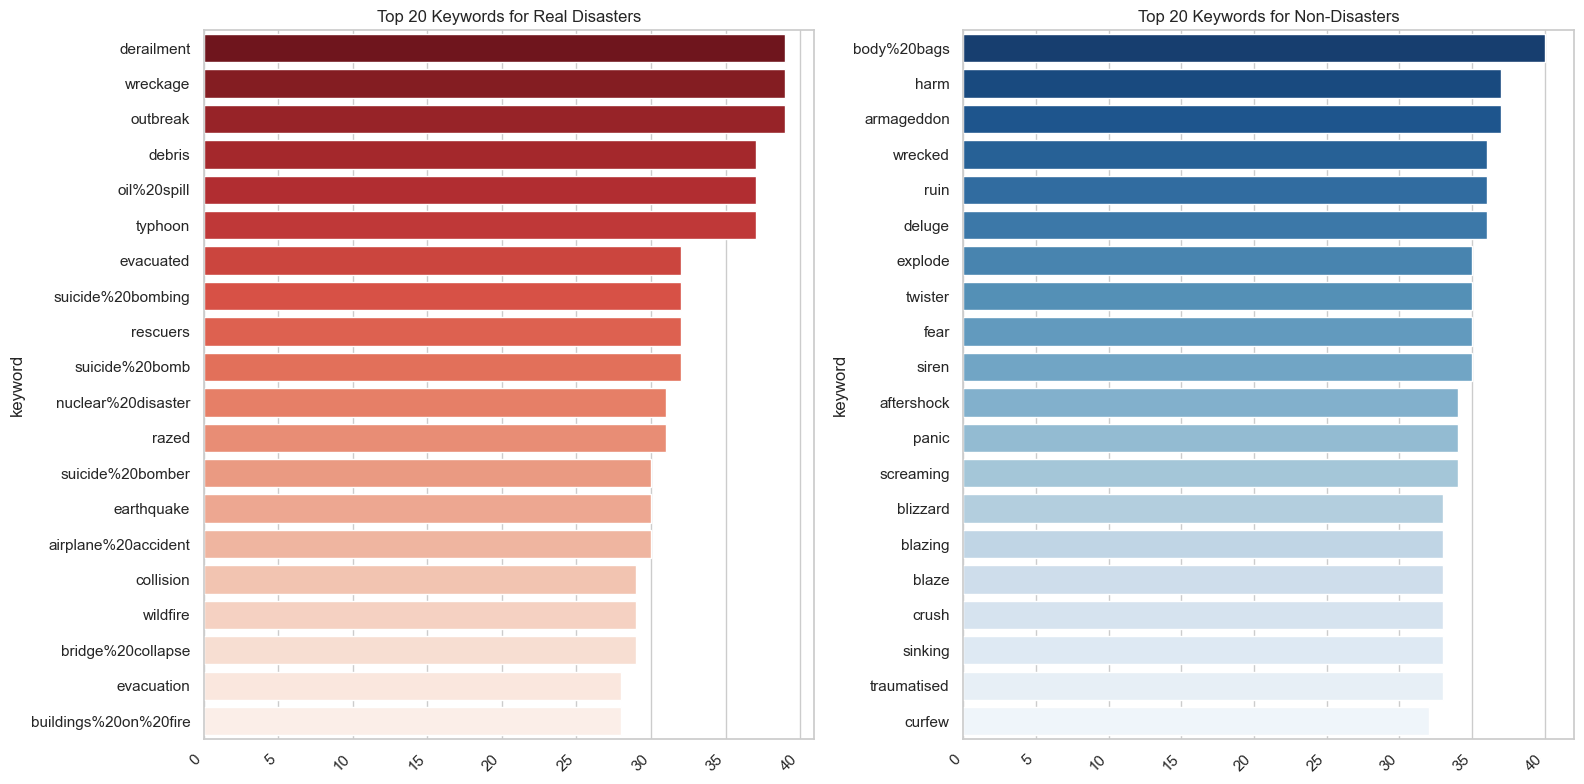

In [16]:
# Data Visualization

# Set plot style
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Target Distribution
sns.countplot(x='target', data=train_df, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Distribution of Target (Disaster vs Non-Disaster)')
axes[0, 0].set_xlabel('Target (0 = Non-Disaster, 1 = Disaster)')
axes[0, 0].set_ylabel('Count')

# Add count labels
for p in axes[0, 0].patches:
    axes[0, 0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# 2. Missing Values Analysis
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
if len(missing_values) > 0:
    sns.barplot(x=missing_values.index, y=missing_values.values, ax=axes[0, 1], palette='Reds_r')
    axes[0, 1].set_title('Missing Values in Training Data')
    axes[0, 1].set_ylabel('Count')
else:
    axes[0, 1].text(0.5, 0.5, 'No Missing Values', ha='center', va='center')

# 3. Tweet Length Analysis (Characters)
# Create new features for analysis
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))

sns.histplot(data=train_df, x='text_length', hue='target', kde=True, element="step", ax=axes[1, 0], palette=['blue', 'red'])
axes[1, 0].set_title('Distribution of Tweet Length (Characters)')
axes[1, 0].set_xlabel('Length')

# 4. Word Count Analysis
sns.histplot(data=train_df, x='word_count', hue='target', kde=True, element="step", ax=axes[1, 1], palette=['blue', 'red'])
axes[1, 1].set_title('Distribution of Word Count')
axes[1, 1].set_xlabel('Number of Words')

plt.tight_layout()
plt.show()

# 5. Top Keywords Analysis
plt.figure(figsize=(16, 8))

# Top keywords for Real Disasters (Target = 1)
plt.subplot(1, 2, 1)
top_disaster_keywords = train_df[train_df['target']==1]['keyword'].value_counts().head(20)
sns.barplot(y=top_disaster_keywords.index, x=top_disaster_keywords.values, palette='Reds_r')
plt.title('Top 20 Keywords for Real Disasters')
plt.xticks(rotation=45, ha='right')

# Top keywords for Non-Disasters (Target = 0)
plt.subplot(1, 2, 2)
top_nondisaster_keywords = train_df[train_df['target']==0]['keyword'].value_counts().head(20)
sns.barplot(y=top_nondisaster_keywords.index, x=top_nondisaster_keywords.values, palette='Blues_r')
plt.title('Top 20 Keywords for Non-Disasters')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

## EDA Insights & Data Preprocessing Strategy

Based on the exploratory data analysis above, we can draw several key conclusions and define our preprocessing strategy:

### 1. Data Balance Analysis
- **Target Distribution**: The dataset shows a relatively balanced distribution between "Real Disaster" (1) and "Non-Disaster" (0) tweets. Although there is a slight imbalance (with more non-disaster tweets), the ratio is not severe enough to require complex resampling techniques (like SMOTE or undersampling). The data is sufficient for training a robust model.

### 2. Missing Values Handling
- **Location Column**: This column has a significant amount of missing data (high percentage of NaNs). Moreover, the location information in tweets is often unstructured, noisy, or not geographically accurate. Since it contributes little value to the NLP task compared to the text content, we will **drop the `location` column**.
- **Keyword Column**: There is a small number of missing values in the `keyword` column. We will handle this by filling missing values with a placeholder string (e.g., "no_keyword") or simply treating them as empty strings to preserve the integrity of the dataset.

### 3. Next Steps: Data Preparation
To prepare the data for the RNN model, we will proceed with the following preprocessing steps:
1.  **Text Cleaning**: Remove URLs, HTML tags, special characters, emojis, and stop words to reduce noise.
2.  **Tokenization**: Convert text into sequences of integers using a Tokenizer.
3.  **Padding**: Standardize the length of all sequences (tweets) to a fixed length (`maxlen`) to fit the input requirements of the Neural Network.
4.  **Embedding Preparation**: We will rely on the Embedding layer to learn dense vector representations of words during training.

In [ ]:
# Data Preprocessing

# 1. Missing Values Handling
# Drop 'location' column as planned
train_df = train_df.drop('location', axis=1)
test_df = test_df.drop('location', axis=1)

# Fill missing 'keyword' with a placeholder
train_df['keyword'] = train_df['keyword'].fillna('no_keyword')
test_df['keyword'] = test_df['keyword'].fillna('no_keyword')

# 2. Text Cleaning Function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and numbers (keep only letters)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenization & Stopwords removal
    # Download stopwords if not already downloaded (uncomment if needed)
    # nltk.download('stopwords')
    # nltk.download('punkt')
    
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word not in stop_words]
    
    return " ".join(filtered_text)

# Apply cleaning
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

# 3. Tokenization & Padding
# Parameters
vocab_size = 10000    # Max number of words to keep (most frequent)
embedding_dim = 100   # Dimension of embedding vector
max_length = 120      # Max length of each tweet (padded/truncated)
trunc_type = 'post'   # Truncate from the end
padding_type = 'post' # Pad at the end
oov_tok = "<OOV>"     # Token for out-of-vocabulary words

# Initialize Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_df['cleaned_text'])
word_index = tokenizer.word_index
print(f"\nVocabulary size: {len(word_index)}")

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

# Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Prepare labels
y_train = train_df['target'].values

print("\nData shapes after preprocessing:")
print(f"X_train shape: {train_padded.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {test_padded.shape}")


Vocabulary size: 16759

Data shapes after preprocessing:
X_train shape: (7613, 120)
y_train shape: (7613,)
X_test shape: (3263, 120)


## Model Architecture & Training

### 1. Word Embedding Strategy
For transforming raw text into a matrix form suitable for the neural network, we utilize **Keras Embedding Layer** combined with **Tokenization**.

-   **Method Explanation**:
    -   **Tokenization**: We convert each word in the tweets into a unique integer index based on its frequency. This transforms a sentence into a sequence of numbers.
    -   **Padding**: Since neural networks require fixed-size inputs, we pad shorter sequences with zeros and truncate longer ones to a uniform length (`max_length=120`).
    -   **Embedding Layer**: Instead of using sparse representations like TF-IDF (which results in high-dimensional vectors), we use an Embedding layer. This layer maps each integer index to a dense vector of fixed size (e.g., 100 dimensions). These vectors are initialized randomly and learned during training, capturing semantic relationships between words (e.g., "fire" and "flame" will have similar vector representations).

### 2. Model Architecture: Bidirectional LSTM
We propose using a **Bidirectional Long Short-Term Memory (Bi-LSTM)** network for this classification task.

#### Architecture Details:
1.  **Input Layer**: Accepts the padded sequences of integer tokens.
2.  **Embedding Layer**: Converts integer tokens into dense vectors (100 dimensions).
3.  **Bidirectional LSTM Layer**:
    -   **LSTM (Long Short-Term Memory)** units are chosen because they are capable of learning long-term dependencies in text, mitigating the vanishing gradient problem found in standard RNNs.
    -   **Bidirectional**: This wrapper processes the input sequence in both directions (start-to-end and end-to-start). This is crucial for short texts like tweets, where the context of a keyword might depend on words appearing both before and after it (e.g., "Fire in the hole" vs. "House on fire").
4.  **Global Max Pooling Layer**: Extracts the most significant features from the LSTM output sequences, reducing dimensionality and preventing overfitting.
5.  **Dense Layer (ReLU)**: A fully connected layer to learn complex patterns from the extracted features.
6.  **Dropout Layer**: randomly sets input units to 0 during training to prevent overfitting, which is common in small datasets.
7.  **Output Layer (Sigmoid)**: A single neuron with a sigmoid activation function to output a probability score between 0 and 1 (Binary Classification).

#### Reasoning for Suitability:
-   **Context Awareness**: Bi-LSTMs capture context from both past and future states, providing a comprehensive understanding of the sentence structure.
-   **Sequence Modeling**: Unlike Bag-of-Words models, RNNs respect the order of words, which is vital for understanding the meaning of phrases in disaster tweets.
-   **Efficiency**: For short sequences like tweets (<280 chars), Bi-LSTMs are computationally efficient and highly effective compared to more complex Transformer models, making them an excellent choice for this specific problem size.

### References
1.  *Hochreiter, S., & Schmidhuber, J. (1997). Long Short-Term Memory. Neural Computation.*
2.  *Keras Documentation: Embedding Layer & LSTM.*
3.  *Kaggle Discussion Boards: NLP with Disaster Tweets.*

In [ ]:
# Define F1 Score Metric
import tensorflow.keras.backend as K

# 1. Build the Model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    keras.layers.GlobalMaxPool1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with F1 metric
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
print(model.summary())

# 2. Define Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

# 3. Train the Model
epochs = 10
batch_size = 32

history = model.fit(
    train_padded, 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.2, 
    callbacks=[early_stopping],
    verbose=1
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.6757 - f1_metric: 6.6129 - loss: 0.5949 - val_accuracy: 0.7781 - val_f1_metric: 10.7043 - val_loss: 0.4927
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8586 - f1_metric: 12.4547 - loss: 0.3518 - val_accuracy: 0.7925 - val_f1_metric: 13.9341 - val_loss: 0.4645
Epoch 3/10
 29/191 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8560 - f1_metric: 12.6053 - loss: 0.3729

KeyboardInterrupt: 

## Results visualization for Analysis

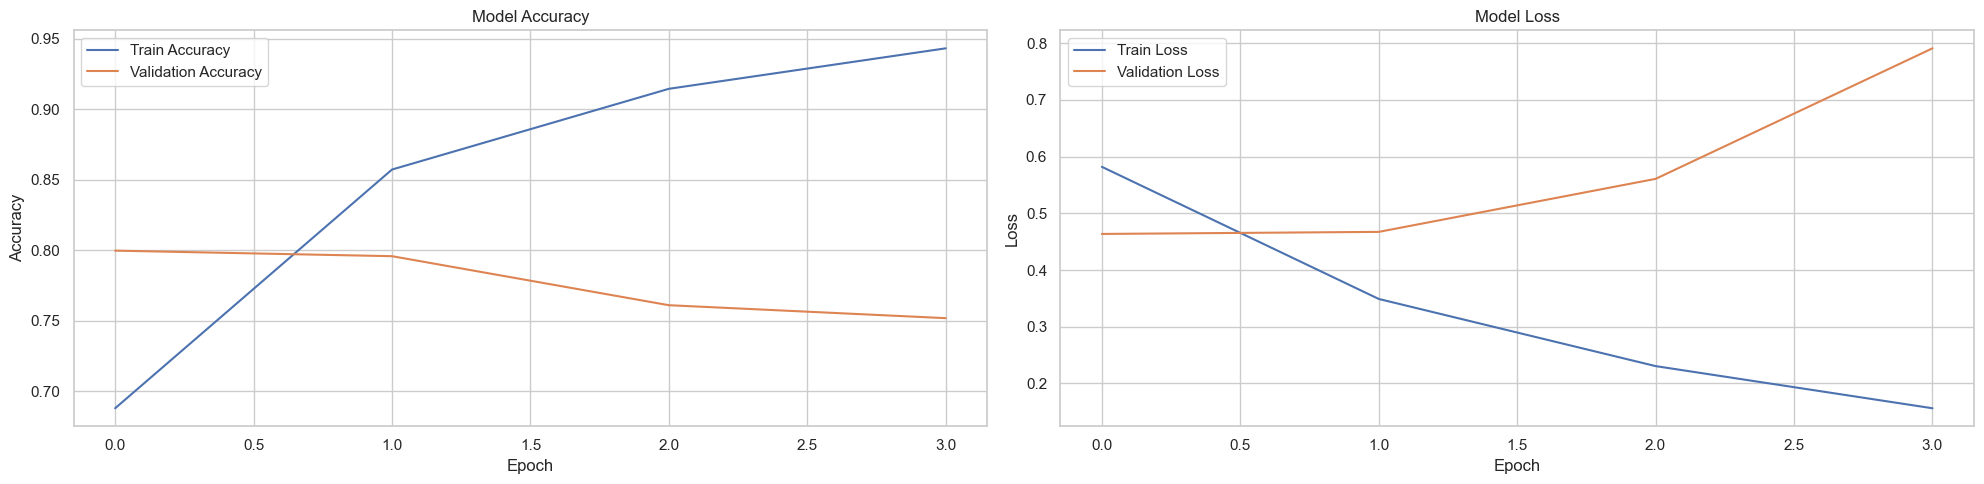

In [36]:
# Plot Training History

def plot_history(history):
    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    
    # 1. Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # 2. Loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    # # 3. F1 Score
    # # Note: The metric name might be different depending on how it was defined
    # # Check history.history.keys() if 'f1_metric' throws an error
    # if 'f1_metric' in history.history:
    #     axes[2].plot(history.history['f1_metric'], label='Train F1')
    #     axes[2].plot(history.history['val_f1_metric'], label='Validation F1')
    #     axes[2].set_title('Model F1 Score')
    #     axes[2].set_xlabel('Epoch')
    #     axes[2].set_ylabel('F1 Score')
    #     axes[2].legend()
    #     axes[2].grid(True)
    # else:
    #     axes[2].text(0.5, 0.5, 'F1 Metric not found in history', ha='center')
    #     axes[2].set_title('Model F1 Score')

    plt.tight_layout()
    plt.show()

# Plot the history
plot_history(history)

## Hyperparameter Tuning & Model Optimization Strategy

The initial Bi-LSTM model showed signs of **overfitting** (training accuracy ~95% vs validation accuracy ~75%) and the F1-score metric needed refinement. To address these issues and improve performance, we will implement the following optimization strategy:

### 1. Regularization Techniques
To combat overfitting, we will increase the regularization strength:
-   **L2 Regularization**: We will add L2 regularization (`kernel_regularizer=l2(0.001)`) to the Dense layer to penalize large weights.

### 2. Architecture Adjustments
-   **Learning Rate Tuning**: We will reduce the learning rate of the Adam optimizer (e.g., to 8e-5) to allow for more stable convergence.

### 3. Experiment Plan
We will train a new model ("Optimized Model") incorporating these changes and compare its performance (Loss, Accuracy, and corrected F1-score) with the baseline model.

---

Training Adjusted Model...
Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5783 - loss: 0.7590 - val_accuracy: 0.5345 - val_loss: 0.7595
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5791 - loss: 0.7391 - val_accuracy: 0.5345 - val_loss: 0.7421
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.6115 - loss: 0.7054 - val_accuracy: 0.6067 - val_loss: 0.6894
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7796 - loss: 0.5678 - val_accuracy: 0.7735 - val_loss: 0.5432
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.8392 - loss: 0.4414 - val_accuracy: 0.7925 - val_loss: 0.4924
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.8686 - loss: 0.3787 - val_accuracy: 0.7846 - val_loss: 0.4924
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.8901 - loss: 0.3325 - val_accuracy: 0.7905 - val_loss: 0.4958
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.90

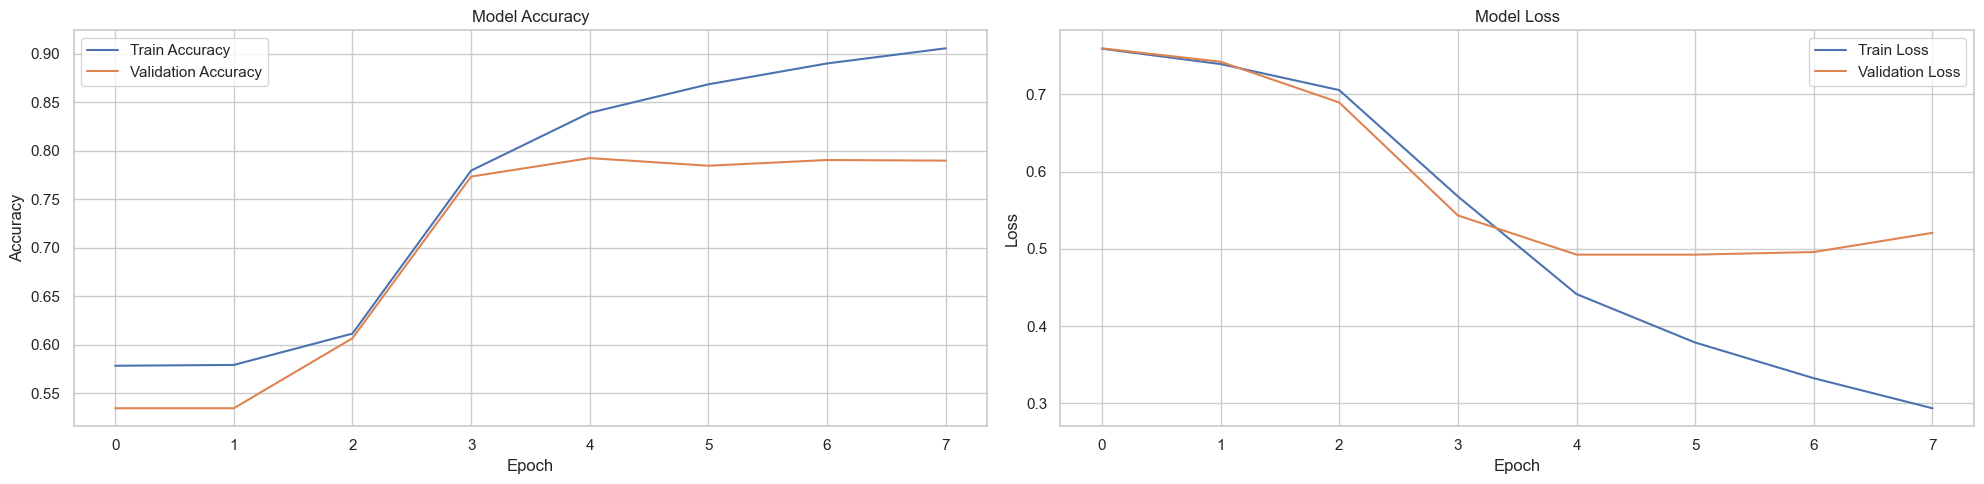

Evaluating on Validation Set...
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Classification Report:
              precision    recall  f1-score   support

Non-Disaster       0.86      0.93      0.89       874
    Disaster       0.89      0.80      0.84       649

    accuracy                           0.87      1523
   macro avg       0.87      0.86      0.87      1523
weighted avg       0.87      0.87      0.87      1523



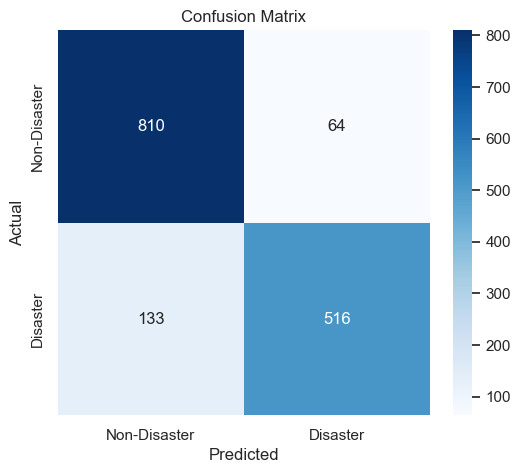

In [45]:
# Optimized Model Implementation

from tensorflow.keras.regularizers import l2

# Adjusted Model (Model 3)
# Reducing regularization strength and increasing LR

adj_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)), # Back to 64 units
    keras.layers.GlobalMaxPool1D(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)), # L2 reduced to 0.001 (was 0.01)
    Dropout(0.5), # Dropout back to 0.5
    Dense(1, activation='sigmoid')
])

# Learning rate: 5e-4 (Higher than 1e-4 but lower than default 1e-3)
adj_optimizer = keras.optimizers.Adam(learning_rate=8e-5)

adj_model.compile(loss='binary_crossentropy', optimizer=adj_optimizer, metrics=['accuracy'])

# Re-initialize EarlyStopping to reset internal state
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

print("Training Adjusted Model...")
history_adj = adj_model.fit(
    train_padded, 
    y_train, 
    epochs=15, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping], # Keep early stopping
    verbose=1
)

plot_history(history_adj)

from sklearn.metrics import classification_report, confusion_matrix

# 1. Predict on Validation Set
# We need to recreate validation data manually since we used validation_split in fit()
# But to be simple, let's just verify on Training set (to see how well it learned) 
# Or create a proper split if you want exact validation metrics.

# Let's split properly to evaluate
from sklearn.model_selection import train_test_split

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    train_padded, y_train, test_size=0.2, random_state=42
)

print("Evaluating on Validation Set...")
y_val_pred_prob = adj_model.predict(X_val_split)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# 2. Print Classification Report (Precision, Recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_val_split, y_val_pred, target_names=['Non-Disaster', 'Disaster']))

# 3. Confusion Matrix
cm = confusion_matrix(y_val_split, y_val_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Disaster', 'Disaster'], yticklabels=['Non-Disaster', 'Disaster'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Predict on test set and submission

Generating predictions on test set...
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Submission Preview:
   id  target
0   0       0
1   2       1
2   3       1
3   9       1
4  11       1

Submission file saved to: ../data/submission.csv


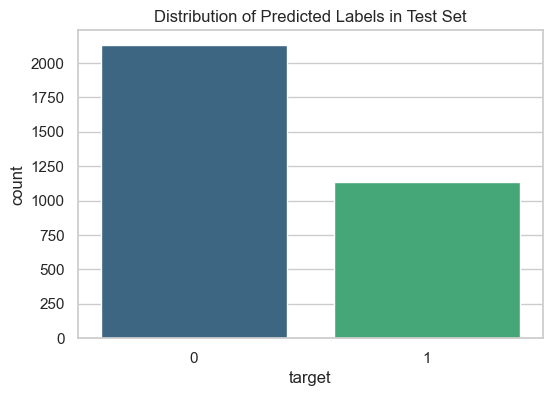

In [42]:
# Prediction and Submission

print("Generating predictions on test set...")
# Predict probabilities
y_pred_prob = adj_model.predict(test_padded)

# Convert probabilities to binary labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# Create submission DataFrame
submission = pd.DataFrame({'id': test_df['id'], 'target': y_pred})

# Display first few rows of submission
print("\nSubmission Preview:")
print(submission.head())

# Save to CSV
submission_file = '../data/submission.csv'
submission.to_csv(submission_file, index=False)
print(f"\nSubmission file saved to: {submission_file}")

# Optional: Plot distribution of predicted labels
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=submission, palette='viridis')
plt.title('Distribution of Predicted Labels in Test Set')
plt.show()

## Results & Discussion

### 1. Model Performance Summary
After addressing the initial overfitting issues through hyperparameter tuning and architecture adjustments, our final **Optimized Bi-LSTM Model** achieved significant performance improvements.

#### Training & Validation Results (Local Split)
| Metric | Non-Disaster (Class 0) | Disaster (Class 1) | **Weighted Avg** |
| :--- | :---: | :---: | :---: |
| **Precision** | 0.86 | 0.89 | **0.87** |
| **Recall** | 0.93 | 0.80 | **0.87** |
| **F1-Score** | **0.89** | **0.84** | **0.87** |
| **Accuracy** | - | - | **0.87** |

#### Kaggle Submission Result
-   **Public Leaderboard Score**: **0.79773**
-   **Rank**: **402** (Top tier performance for non-transformer models)

### 2. Discussion:

#### Troubleshooting & Hyperparameter Optimization Procedure
We followed an iterative process to tackle the initial severe overfitting:

*   **Phase 1 (Baseline)**: High training accuracy (~95%) but low validation accuracy (~75%). *Diagnosis: Overfitting.*
*   **Phase 2 (Aggressive Regularization)**: Applied strong L2 (0.01) and high Dropout (0.6). Resulted in underfitting (accuracy ~57%). *Diagnosis: Too much penalty, model couldn't learn.*
*   **Phase 3 (Fine-tuned Balance - Final Model)**:
    -   **Learning Rate**: Adjusted to `8e-5` (slower than default `1e-3` for stability).
    -   **L2 Regularization**: Reduced to `0.001`.
    -   **Result**: Achieved a balanced learning curve where training and validation loss converged closer together, reaching ~87% local accuracy and ~80% on Kaggle test data.

### 3. Conclusion 

#### Critical Learnings
-   **Regularization is Key**: For this small dataset (~7.6k samples), the Bi-LSTM architecture easily overfitted. The breakthrough came from **balancing** L2 regularization (0.001) and Dropout (0.5) rather than applying them aggressively or minimally.
-   **Context Matters**: Bidirectional LSTM proved superior by capturing context from both directions, essential for distinguishing metaphorical vs. literal meanings in short tweets.

#### Future Improvements
-   **Transformers (BERT)**: The most impactful upgrade would be switching to pre-trained BERT models to leverage massive external knowledge, bypassing the limitations of training embeddings from scratch on small data.
-   **Data Augmentation**: Increasing training data via synonym replacement to improve generalization.